# **Imoprting important libraries**

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
import string
import progressbar
from collections import Counter 
from copy import copy
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
warnings.filterwarnings("ignore")

# **Loading the data**

In [ ]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download hsankesara/flickr-image-dataset
! unzip /content/flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

# **Data paths and size**


In [ ]:
captions_path = "flickr30k_images/flickr30k_images/results.csv"
images_path = "flickr30k_images/flickr30k_images/flickr30k_images"

In [ ]:
images = os.listdir(images_path)
len(images)

31783

In [ ]:
def load_csv(directory):
    desc=dict()
    text = pd.read_csv(directory, delimiter='|',header=None,
                       names=["image_name","comment_number",
                              "comment"])
    text = text.iloc[1:,:]
    df_new = text[text.iloc[:,2].notnull()]
    return df_new 

In [ ]:
data = load_csv(captions_path)
data

,image_name,comment_number,comment
1,1000092795.jpg,0,Two young guys with shaggy hair look at their...
2,1000092795.jpg,1,"Two young , White males are outside near many..."
3,1000092795.jpg,2,Two men in green shirts are standing in a yard .
4,1000092795.jpg,3,A man in a blue shirt standing in a garden .
5,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158911,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158912,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158913,998845445.jpg,2,A man is leaning off of the side of a blue an...
158914,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [ ]:
uni_filenames = np.unique(data.image_name.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.image_name.values).values())

The number of unique file names : 31783
The distribution of the number of captions for each image:


Counter({5: 31782, 4: 1})

# **Data visualization**

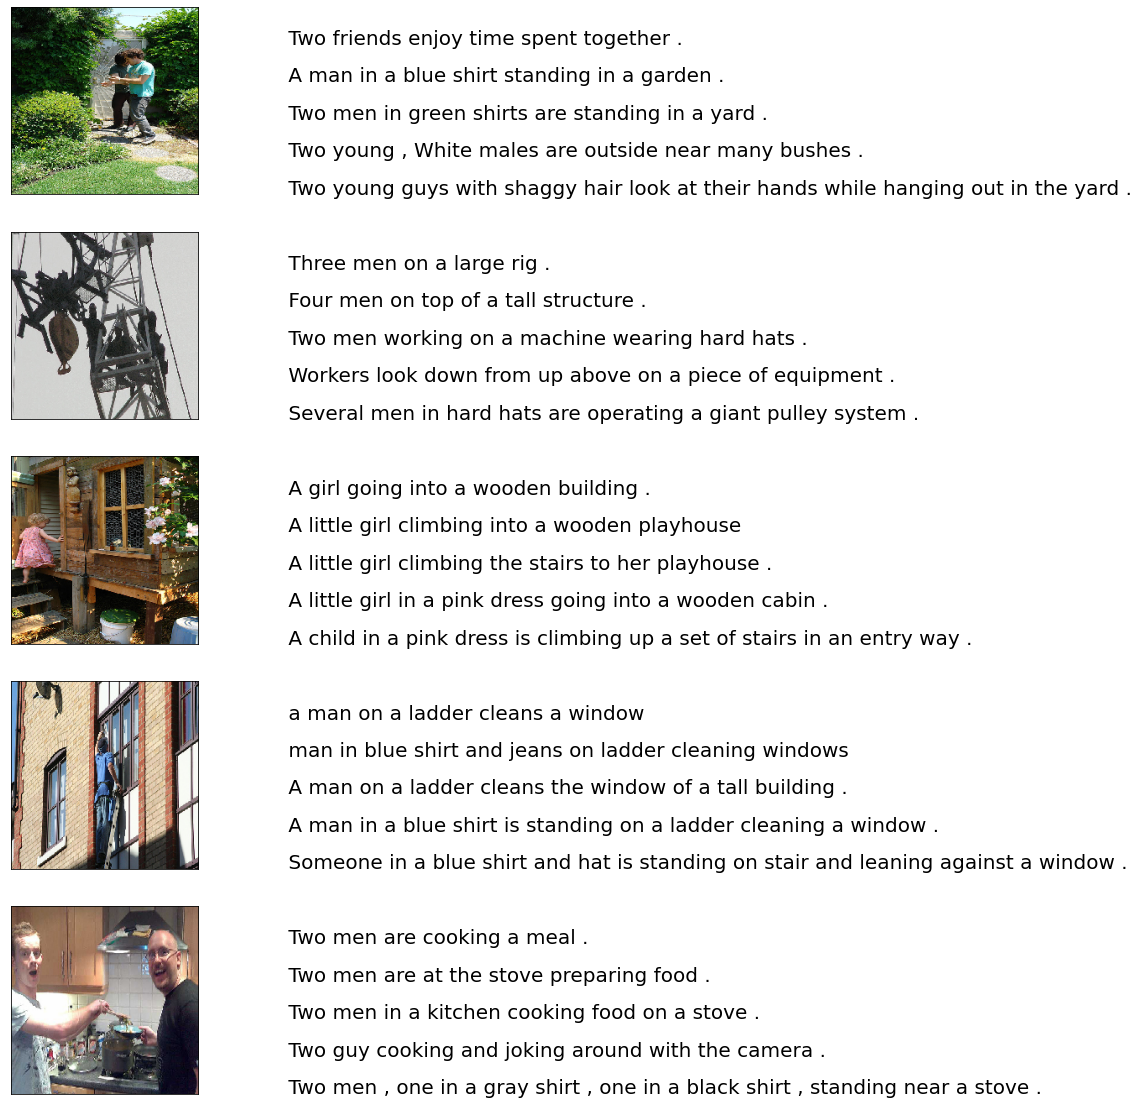

In [ ]:
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:5]:
    filename = images_path + '/' + jpgfnm
    captions = list(data["comment"].loc[data["image_name"]==jpgfnm].values)

    image_load = load_img(filename, target_size=(224,224,3))
    
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
del uni_filenames

# **Most and least repeated words**

In [ ]:
def df_word(df_txt):
    vocabulary = []

    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())

    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(data)
dfword.head()

Vocabulary Size: 23457


,word,count
0,a,181627
1,.,151037
2,A,90070
3,in,83224
4,the,57401


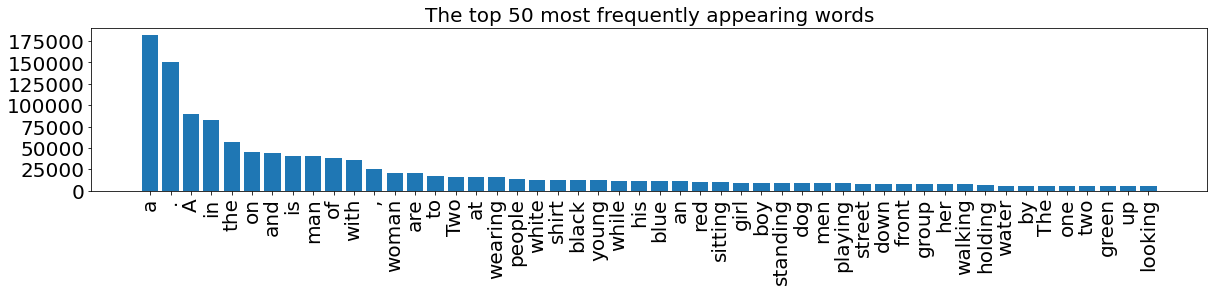

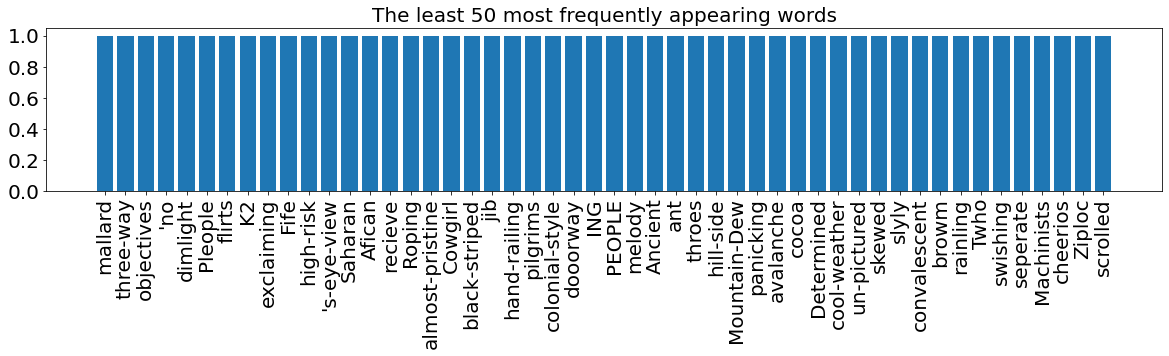

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
del df_word

# **Cleaning the data**

In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

with progressbar.ProgressBar(max_value=len(data.comment.values)) as bar:
    for i, caption in enumerate(data.comment.values):
        newcaption = text_clean(caption)
        data["comment"].iloc[i] = newcaption
        bar.update(i)

100% (158914 of 158914) |################| Elapsed Time: 0:02:21 Time:  0:02:21


# **Adding start and end tokens to captions**

In [ ]:
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df_captions = copy(data)
df_captions["comment"] = add_start_end_seq_token(data["comment"])
del data
df_captions

,image_name,comment_number,comment
1,1000092795.jpg,0,startseq Two young guys with shaggy hair look...
2,1000092795.jpg,1,startseq Two young White males are outside ne...
3,1000092795.jpg,2,startseq Two men in green shirts are standing...
4,1000092795.jpg,3,startseq man in blue shirt standing in garden...
5,1000092795.jpg,4,startseq Two friends enjoy time spent togethe...
...,...,...,...
158911,998845445.jpg,0,startseq man in shorts and Hawaiian shirt lea...
158912,998845445.jpg,1,startseq young man hanging over the side of b...
158913,998845445.jpg,2,startseq man is leaning off of the side of bl...
158914,998845445.jpg,3,startseq man riding small boat in harbor with...


# **Feature extraction using ResNet50 model**

In [ ]:
resnet_model = ResNet50(include_top=True)

102981632/102967424 [==============================] - 0s 0us/step


In [ ]:
from keras.models import Model
last = resnet_model.layers[-2].output
res_model = Model(inputs = resnet_model.input,outputs = last)
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
images1 = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(images)) as bar:
    for i,name in enumerate(images):
        # load an image from file
        filename = images_path + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = res_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images1[name] = y_pred.flatten()
        bar.update(i)
del images

100% (31783 of 31783) |##################| Elapsed Time: 0:27:28 Time:  0:27:28


In [ ]:
dimages, keepindex = [],[]

nd=(df_captions["comment_number"].values)
b = [(int(i)==0) for i in nd]
df_captions = df_captions.loc[b,: ]

for i, fnm in enumerate(df_captions.image_name):
  if fnm in images1.keys():
    dimages.append(images1[fnm])
    keepindex.append(i)
        
fnames = df_captions["image_name"].iloc[keepindex].values
dcaptions = df_captions["comment"].iloc[keepindex].values
dimages = np.array(dimages)

In [ ]:
df_captions

,image_name,comment_number,comment
1,1000092795.jpg,0,startseq Two young guys with shaggy hair look...
6,10002456.jpg,0,startseq Several men in hard hats are operati...
11,1000268201.jpg,0,startseq child in pink dress is climbing up s...
16,1000344755.jpg,0,startseq Someone in blue shirt and hat is sta...
21,1000366164.jpg,0,startseq Two men one in gray shirt one in bla...
...,...,...,...
158891,997338199.jpg,0,startseq Woman writing on pad in room with go...
158896,997722733.jpg,0,startseq person in red shirt climbing up rock...
158901,997876722.jpg,0,startseq Two male construction workers are wo...
158906,99804383.jpg,0,startseq An older busker in glasses plays an ...


In [ ]:
del keepindex

# **Data tokenization**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 12992
[[1, 18, 26, 493, 6, 2077, 90, 158, 22, 61, 125, 19, 312, 86, 3, 4, 535, 2], [1, 107, 36, 3, 338, 248, 15, 1574, 801, 3473, 2261, 2], [1, 72, 3, 74, 100, 9, 309, 52, 345, 8, 469, 3, 20, 2979, 562, 2], [1, 279, 3, 21, 16, 5, 53, 9, 27, 7, 3189, 5, 315, 191, 239, 2], [1, 18, 36, 28, 3, 89, 16, 28, 3, 17, 16, 27, 98, 1425, 2]]


In [ ]:
Ntest = int(len(dtexts)*0.3)

def split_test_val_train(dtexts,Ntest):
    return(dtexts[:Ntest],  
           dtexts[Ntest:])

dt_test, dt_train   = split_test_val_train(dtexts,Ntest)
di_test, di_train   = split_test_val_train(dimages,Ntest)
fnm_test, fnm_train  = split_test_val_train(fnames,Ntest)

In [ ]:
del df_captions
del images1

# **Data preprocessing**

In [ ]:
df_split_captions_tokenized = np.array_split(dt_train, 2)

In [ ]:
df_split_images = np.array_split(di_train, 2)

In [ ]:
def preprocessing(dtexts,dimages):
    print("# captions/images = {}".format(len(dtexts)))

    assert(len(dtexts)==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=np.max([len(text) for text in dtexts])).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


In [ ]:
Xtext_train, Ximage_train, ytext_train = preprocessing(df_split_captions_tokenized[0],df_split_images[0])

# captions/images = 11125
 (178893, 59) (178893, 2048) (178893, 12992)


In [ ]:
from keras import layers
from keras.regularizers import l2
from keras import models

print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
droplayer1 = layers.Dropout(0.5)(input_image)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature1",kernel_regularizer=l2(0.01))(BN)
droplayer1 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature3",kernel_regularizer=l2(0.01))(BN)
droplayer2 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer2)
fimage2 = layers.Dense(256, activation='relu')(BN)


## sequence model
input_txt = layers.Input(shape=(59,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
droplayer_ = layers.Dropout(0.5)(ftxt)
BN = layers.BatchNormalization()(droplayer_)
ftxt = layers.LSTM(256,name="CaptionFeature")(BN)


## combined model for decoder
decoder = layers.add([ftxt,fimage2])
decoder = layers.Dense(256,activation='relu')(decoder)
droplayer1 = layers.Dropout(0.5)(decoder)
BN = layers.BatchNormalization()(droplayer1)
output = layers.Dense(vocab_size,activation='softmax')(BN)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

12992
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048)        8192        ['dropout[0][0]']                
 alization)                                                                                       
                                                                                                  
 ImageFeature1 (Dense)          (None, 256)          524544      ['batch_normalization

In [ ]:
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=100, verbose=2, 
                  batch_size=64,
                  validation_split=0.05)

Epoch 1/100
2656/2656 - 345s - loss: 6.6526 - accuracy: 0.1544 - val_loss: 5.4965 - val_accuracy: 0.2032 - 345s/epoch - 130ms/step
Epoch 2/100
2656/2656 - 336s - loss: 5.1691 - accuracy: 0.2049 - val_loss: 5.0059 - val_accuracy: 0.2209 - 336s/epoch - 127ms/step
Epoch 3/100
2656/2656 - 334s - loss: 4.8374 - accuracy: 0.2202 - val_loss: 4.8930 - val_accuracy: 0.2333 - 334s/epoch - 126ms/step
Epoch 4/100
2656/2656 - 331s - loss: 4.6937 - accuracy: 0.2309 - val_loss: 4.8661 - val_accuracy: 0.2366 - 331s/epoch - 125ms/step
Epoch 5/100
2656/2656 - 333s - loss: 4.5924 - accuracy: 0.2361 - val_loss: 4.8771 - val_accuracy: 0.2410 - 333s/epoch - 125ms/step
Epoch 6/100
2656/2656 - 333s - loss: 4.5035 - accuracy: 0.2423 - val_loss: 4.8038 - val_accuracy: 0.2437 - 333s/epoch - 125ms/step
Epoch 7/100
2656/2656 - 333s - loss: 4.4371 - accuracy: 0.2460 - val_loss: 4.8128 - val_accuracy: 0.2432 - 333s/epoch - 125ms/step
Epoch 8/100
2656/2656 - 332s - loss: 4.3960 - accuracy: 0.2490 - val_loss: 4.8115 -